# Overlaid Arrow Image Generator Notebook

To support training and inference of the arrow detector, we want to create a pipeline to generate images with a variety of different arrow PNGs randomnly overlaid onto medical images of varying modalities.

In [1]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import os

In [2]:
def resize_to_width(image_rgb, target_w=1024, interpolation=cv2.INTER_LINEAR):
    """
    Resize an RGB image to the specified width while preserving aspect ratio.

    Parameters:
    - image_rgb: np.ndarray (H,W,3) in RGB
    - target_w: int target width (default: 1024)
    - interpolation: OpenCV interpolation method

    Returns:
    - resized RGB image with width == target_w
    """
    h, w = image_rgb.shape[:2]
    if w == target_w:
        return image_rgb
    target_h = int(round(h * (target_w / w)))
    return cv2.resize(image_rgb, (target_w, target_h), interpolation=interpolation)

In [97]:
def bboxes_overlap(bbox1, bbox2):
    """
    Check if two bounding boxes overlap.
    
    Parameters:
    - bbox1, bbox2: (x_min, y_min, x_max, y_max) bounding boxes
    
    Returns:
    - bool: True if bounding boxes overlap
    """
    x_min1, y_min1, x_max1, y_max1 = bbox1
    x_min2, y_min2, x_max2, y_max2 = bbox2
    
    # Check if X ranges intersect
    x_overlap = not (x_max1 < x_min2 or x_max2 < x_min1)
    
    # Check if Y ranges intersect
    y_overlap = not (y_max1 < y_min2 or y_max2 < y_min1)
    
    # Both must overlap for bboxes to overlap
    return x_overlap and y_overlap

In [217]:
def generate_contrasting_color(background_color):
    """
    Generate a color that contrasts with the background.
    Generates 3 colors from each color family, ranks all by contrast, takes top 15.
    
    Parameters:
    - background_color: tuple (R, G, B) average color of the background region
    
    Returns:
    - tuple (R, G, B) contrasting color
    """
    # Define RGB ranges for each color family: (R_min, R_max, G_min, G_max, B_min, B_max)
    color_ranges = {
        'red': (150, 255, 0, 80, 0, 80),
        'green': (0, 80, 150, 255, 0, 80),
        'blue': (0, 80, 0, 80, 150, 255),
        'white': (220, 255, 220, 255, 220, 255),
        'black': (0, 40, 0, 40, 0, 40),
        'gray': (80, 180, 80, 180, 80, 180),
        'yellow': (200, 255, 200, 255, 0, 80),
        'cyan': (0, 80, 200, 255, 200, 255),
        'magenta': (200, 255, 0, 80, 200, 255),
        'orange': (220, 255, 100, 180, 0, 60),
    }
    
    bg_r, bg_g, bg_b = background_color
    
    # Generate 3 random colors from each family and calculate their contrast scores
    all_colors = []  # List of (color, contrast_score)
    
    for name, (r_min, r_max, g_min, g_max, b_min, b_max) in color_ranges.items():
        for _ in range(3):
            if name == 'gray':
                val = random.randint(g_min, g_max)
                r, g, b = val, val, val
            else:
                r = random.randint(r_min, r_max)
                g = random.randint(g_min, g_max)
                b = random.randint(b_min, b_max)
            
            # Calculate contrast score (sum of squared RGB differences)
            contrast_score = (r - bg_r)**2 + (g - bg_g)**2 + (b - bg_b)**2
            all_colors.append(((r, g, b), contrast_score))
    
    # Sort by contrast score (highest first) and take top 15
    all_colors.sort(key=lambda x: x[1], reverse=True)
    color_pool = [color for color, score in all_colors[:15]]
    
    # Add bonus entries for black/white if they have excellent contrast
    min_bw_contrast = 100000  # Sum of squared diffs; max is 195075 (black vs white)
    bonus_count = 3
    
    # Calculate white contrast
    white_center = (237, 237, 237)
    white_contrast = (white_center[0] - bg_r)**2 + (white_center[1] - bg_g)**2 + (white_center[2] - bg_b)**2
    if white_contrast >= min_bw_contrast:
        r_min, r_max, g_min, g_max, b_min, b_max = color_ranges['white']
        for _ in range(bonus_count):
            r = random.randint(r_min, r_max)
            g = random.randint(g_min, g_max)
            b = random.randint(b_min, b_max)
            color_pool.append((r, g, b))
    
    # Calculate black contrast
    black_center = (20, 20, 20)
    black_contrast = (black_center[0] - bg_r)**2 + (black_center[1] - bg_g)**2 + (black_center[2] - bg_b)**2
    if black_contrast >= min_bw_contrast:
        r_min, r_max, g_min, g_max, b_min, b_max = color_ranges['black']
        for _ in range(bonus_count):
            r = random.randint(r_min, r_max)
            g = random.randint(g_min, g_max)
            b = random.randint(b_min, b_max)
            color_pool.append((r, g, b))
    
    # Randomly pick from the pool
    return random.choice(color_pool)


def get_arrow_average_color(arrow_path):
    """
    Get the average color of non-transparent pixels in an arrow PNG.
    
    Parameters:
    - arrow_path: path to arrow PNG file
    
    Returns:
    - tuple (R, G, B) average color, or None if no non-transparent pixels
    """
    arrow_image = cv2.imread(arrow_path, cv2.IMREAD_UNCHANGED)
    if arrow_image is None:
        return None
    
    if arrow_image.shape[2] == 4:
        alpha = arrow_image[:, :, 3]
        mask = alpha > 0
        if not np.any(mask):
            return None
        bgr = arrow_image[:, :, :3]
        avg_bgr = np.mean(bgr[mask], axis=0)
        # Convert BGR to RGB
        return (int(avg_bgr[2]), int(avg_bgr[1]), int(avg_bgr[0]))
    else:
        # No alpha channel, use all pixels
        avg_bgr = np.mean(arrow_image, axis=(0, 1))
        return (int(avg_bgr[2]), int(avg_bgr[1]), int(avg_bgr[0]))


def has_sufficient_contrast(arrow_color, background_color, min_contrast=100000):
    """
    Check if an arrow color has sufficient contrast against a background.
    Uses sum of squared RGB differences. Max is 195075 (black vs white).
    
    Parameters:
    - arrow_color: tuple (R, G, B) arrow color
    - background_color: tuple (R, G, B) background color
    - min_contrast: minimum contrast score threshold (default 50000)
    
    Returns:
    - bool: True if contrast is sufficient
    """
    ar, ag, ab = arrow_color
    br, bg, bb = background_color
    
    # Sum of squared RGB differences
    contrast_score = (ar - br)**2 + (ag - bg)**2 + (ab - bb)**2
    
    return contrast_score >= min_contrast


# Arrows that need shorter length constraints (max 0.15 instead of 0.3)
SHORT_ARROWS = {'arrow5.png', 'arrow7.png', 'arrow15.png', 'arrow16.png', 'arrow17.png', 'arrow18.png'}


def generate_tip_tail_positions(base_w, base_h, margin_ratio=0.05, max_length_ratio=0.3):
    """
    Generate valid tip and tail positions for an arrow.
    
    Constraints:
    - X difference: 0.05 * width to max_length_ratio * width
    - Y difference: 0.05 * height to max_length_ratio * height
    - Tip and tail must be within margins
    
    Parameters:
    - base_w, base_h: dimensions of the base image
    - margin_ratio: margin from edges as ratio of image size
    - max_length_ratio: maximum ratio for dx/dy (default 0.3, use 0.15 for short arrows)
    
    Returns:
    - tip: (x, y) tuple or None if failed
    - tail: (x, y) tuple or None if failed
    """
    margin_w = int(margin_ratio * base_w)
    margin_h = int(margin_ratio * base_h)
    
    min_dx = int(0.03 * base_w)
    max_dx = int(max_length_ratio * base_w)
    min_dy = int(0.03 * base_h)
    max_dy = int(max_length_ratio * base_h)
    
    max_attempts = 50
    
    for _ in range(max_attempts):
        # Generate tip position within margins
        tip_x = random.randint(margin_w, base_w - margin_w)
        tip_y = random.randint(margin_h, base_h - margin_h)
        
        # Generate delta values within constraints
        dx = random.randint(min_dx, max_dx) * random.choice([-1, 1])
        dy = random.randint(min_dy, max_dy) * random.choice([-1, 1])
        
        # Calculate tail position
        tail_x = tip_x + dx
        tail_y = tip_y + dy
        
        # Check if tail is within image bounds (with some margin)
        if not (margin_w <= tail_x <= base_w - margin_w and margin_h <= tail_y <= base_h - margin_h):
            # Try flipping direction
            tail_x = tip_x - dx
            tail_y = tip_y - dy
            if not (margin_w <= tail_x <= base_w - margin_w and margin_h <= tail_y <= base_h - margin_h):
                continue
        
        return (tip_x, tip_y), (tail_x, tail_y)
    
    return None, None


def get_region_average_color(image_rgb, tip, tail):
    """
    Get the average color of the region defined by tip and tail positions.
    
    Parameters:
    - image_rgb: np.ndarray (H, W, 3) RGB image
    - tip: (x, y) tip position
    - tail: (x, y) tail position
    
    Returns:
    - tuple (R, G, B) average color
    """
    h, w = image_rgb.shape[:2]
    
    # Define bounding box
    x_min = max(0, min(tip[0], tail[0]))
    x_max = min(w, max(tip[0], tail[0]))
    y_min = max(0, min(tip[1], tail[1]))
    y_max = min(h, max(tip[1], tail[1]))
    
    # Extract region
    region = image_rgb[y_min:y_max, x_min:x_max]
    
    if region.size == 0:
        return (128, 128, 128)  # Default gray if region is empty
    
    # Calculate average color
    avg_color = tuple(int(c) for c in np.mean(region, axis=(0, 1)))
    return avg_color

In [218]:
def preprocess_arrow_for_placement(arrow_path, tip, tail, color=None, use_original_color=False, use_inverse_color=False):
    """
    Preprocess arrow PNG to fit between specified tip and tail positions.
    
    Parameters:
    -----------
    arrow_path : string
        Filepath of transparent background arrow image
    tip : tuple
        (x, y) target tip position in output image
    tail : tuple
        (x, y) target tail position in output image
    color : tuple, optional
        RGB color tuple (0-255) to tint the arrow
    use_original_color : bool
        If True, keep original arrow color
    use_inverse_color : bool
        If True, invert the original arrow colors
    
    Returns:
    --------
    arrow_rgb : np.ndarray
        Processed arrow image in RGB format
    alpha : np.ndarray
        Alpha channel for the arrow
    bbox_local : tuple
        (x_min, y_min, x_max, y_max) of non-zero alpha in rotated image coords
    placement_offset : tuple
        (offset_x, offset_y) where to place arrow so tip aligns with target
    """
    arrow_image = cv2.imread(arrow_path, cv2.IMREAD_UNCHANGED)
    
    # Extract BGR and alpha from arrow image
    if arrow_image.shape[2] == 4:
        arrow_bgr = arrow_image[:, :, :3]
        alpha = arrow_image[:, :, 3] / 255.0
    else:
        arrow_bgr = arrow_image
        alpha = np.ones((arrow_image.shape[0], arrow_image.shape[1]))
    
    # Convert arrow from BGR to RGB
    arrow_rgb = cv2.cvtColor(arrow_bgr, cv2.COLOR_BGR2RGB)
    
    # Handle color
    if use_inverse_color:
        mask = alpha > 0
        arrow_rgb[mask] = 255 - arrow_rgb[mask]
    elif not use_original_color and color is not None:
        mask = alpha > 0
        arrow_rgb[...] = 0
        arrow_rgb[mask] = color
    
    # Original arrow dimensions
    orig_h, orig_w = arrow_rgb.shape[:2]
    
    # Determine original tip and tail positions based on arrow type
    # Default: tip is at the right edge center, tail at left edge center
    orig_tip_x, orig_tip_y = orig_w, orig_h // 2
    orig_tail_x, orig_tail_y = 0, orig_h // 2
    
    # Special case adjustments for specific arrow PNGs (offsets in original image coords)
    if arrow_path.endswith('arrow7.png'):
        orig_tail_x += 80  # Tail is not at left edge
    elif arrow_path.endswith('arrow16.png'):
        orig_tail_x += 150  # Tail is not at left edge
    elif arrow_path.endswith('arrow13.png'):
        # Curved arrow: tail at top-left, tip at ~3/4 down on right side
        orig_tail_x = 0
        orig_tail_y = 0
        orig_tip_x = orig_w
        orig_tip_y = int(orig_h * 0.75)
    
    # Calculate target direction and length
    target_dx = tip[0] - tail[0]
    target_dy = tip[1] - tail[1]
    target_length = np.sqrt(target_dx**2 + target_dy**2)
    
    # Calculate original direction and length
    orig_dx = orig_tip_x - orig_tail_x
    orig_dy = orig_tip_y - orig_tail_y
    orig_length = np.sqrt(orig_dx**2 + orig_dy**2)
    
    # Calculate rotation needed
    # Original angle (direction from tail to tip in original image)
    orig_angle = np.degrees(np.arctan2(orig_dy, orig_dx))
    # Target angle (direction from tail to tip in target)
    target_angle = np.degrees(np.arctan2(target_dy, target_dx))
    # Rotation needed (OpenCV uses counter-clockwise positive, but in image coords it appears clockwise)
    rotation_angle = orig_angle - target_angle
    
    # Scale uniformly to match target length exactly
    scale = target_length / orig_length if orig_length > 0 else 1.0
    
    # Apply uniform scaling
    new_w = max(1, int(orig_w * scale))
    new_h = max(1, int(orig_h * scale))
    
    arrow_rgb = cv2.resize(arrow_rgb, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
    alpha = cv2.resize(alpha, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
    
    # Scale tip and tail positions uniformly
    scaled_tip_x = orig_tip_x * scale
    scaled_tip_y = orig_tip_y * scale
    scaled_tail_x = orig_tail_x * scale
    scaled_tail_y = orig_tail_y * scale
    
    h, w = arrow_rgb.shape[:2]
    
    # Rotation around the tail point (so tail stays fixed, tip moves)
    center = (scaled_tail_x, scaled_tail_y)
    rotation_matrix = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)
    
    # Calculate new canvas size to fit rotated image
    corners = np.array([
        [0, 0, 1],
        [w, 0, 1],
        [0, h, 1],
        [w, h, 1]
    ]).T
    
    transformed = rotation_matrix @ corners
    x_coords = transformed[0, :]
    y_coords = transformed[1, :]
    
    x_min = int(np.floor(x_coords.min()))
    x_max = int(np.ceil(x_coords.max()))
    y_min = int(np.floor(y_coords.min()))
    y_max = int(np.ceil(y_coords.max()))
    
    canvas_w = x_max - x_min
    canvas_h = y_max - y_min
    
    # Adjust rotation matrix for new canvas
    rotation_matrix[0, 2] -= x_min
    rotation_matrix[1, 2] -= y_min
    
    # Rotate the arrow and alpha
    arrow_rgb_rotated = cv2.warpAffine(arrow_rgb, rotation_matrix, (canvas_w, canvas_h),
                                        borderMode=cv2.BORDER_CONSTANT,
                                        borderValue=(0, 0, 0))
    alpha_rotated = cv2.warpAffine(alpha, rotation_matrix, (canvas_w, canvas_h),
                                    borderMode=cv2.BORDER_CONSTANT,
                                    borderValue=0)
    
    # Transform tail coordinates to find where tail lands in rotated image
    tail_point = np.array([scaled_tail_x, scaled_tail_y, 1]).reshape(3, 1)
    tail_rotated = rotation_matrix @ tail_point
    tail_local_rotated = (int(round(tail_rotated[0, 0])), int(round(tail_rotated[1, 0])))
    
    # Compute bbox
    ys, xs = np.nonzero(alpha_rotated > 0)
    if len(xs) == 0 or len(ys) == 0:
        bbox_local = (0, 0, 0, 0)
    else:
        bbox_local = (int(xs.min()), int(ys.min()), int(xs.max()), int(ys.max()))
    
    # Calculate placement offset so that arrow tail aligns with target tail
    offset_x = tail[0] - tail_local_rotated[0]
    offset_y = tail[1] - tail_local_rotated[1]
    
    return arrow_rgb_rotated, alpha_rotated, bbox_local, (offset_x, offset_y)


def overlay_arrows_on_image(base_image_rgb, arrow_dir, num_arrows=None):
    """
    Overlay multiple arrows onto a base RGB image with the new placement logic.
    
    Parameters:
    - base_image_rgb: np.ndarray (H, W, 3) RGB image
    - arrow_dir: path to directory containing arrow PNG files
    - num_arrows: int, number of arrows to overlay (default: Gaussian distribution)
    
    Returns:
    - output_rgb: np.ndarray (H, W, 3) RGB image with arrows overlaid
    - tips: list of (x, y) tip locations on output image
    - tails: list of (x, y) tail locations on output image
    - bboxes: list of (x_min, y_min, x_max, y_max) for each overlaid arrow
    """
    base_h, base_w = base_image_rgb.shape[:2]
    
    # Collect arrow PNGs
    arrow_files = [f for f in os.listdir(arrow_dir) if f.lower().endswith(".png")]
    if not arrow_files:
        raise ValueError(f"No PNG files found in {arrow_dir}")
    
    # Determine number of arrows (Gaussian distribution: mean=3, std=2, clipped to [0,8])
    if num_arrows is None:
        num_arrows = int(np.clip(np.round(np.random.normal(3, 2)), 0, 8))
    
    output = base_image_rgb.copy()
    tips = []
    tails = []
    bboxes = []  # Store actual bboxes in output coordinates for overlap checking
    
    # Variables to track first arrow's template and color for consistency
    first_arrow_template = None
    first_arrow_color = None
    first_prefer_original = False
    first_prefer_inverse = False
    first_use_original = False
    first_use_inverse = False
    
    for arrow_idx in range(num_arrows):
        # Determine arrow template FIRST (before generating positions)
        if arrow_idx == 0:
            # First arrow: choose randomly
            first_arrow_template = random.choice(arrow_files)
            arrow_template = first_arrow_template
        else:
            # Subsequent arrows: 90% chance same template as first
            if random.random() < 0.9:
                arrow_template = first_arrow_template
            else:
                arrow_template = random.choice(arrow_files)
        
        # Determine max length ratio based on arrow type
        if arrow_template in SHORT_ARROWS:
            max_length_ratio = 0.10
        else:
            max_length_ratio = 0.25
        
        # Determine preferred color mode (will validate against background later)
        if arrow_idx == 0:
            # First arrow: choose preferred color mode randomly
            color_choice = random.random()
            if color_choice < 0.05:
                first_prefer_inverse = True
                first_prefer_original = False
            elif color_choice < 0.15:
                first_prefer_original = True
                first_prefer_inverse = False
            else:
                first_prefer_original = False
                first_prefer_inverse = False
            
            prefer_original = first_prefer_original
            prefer_inverse = first_prefer_inverse
            first_arrow_color = None
        else:
            # Subsequent arrows: same color style if same template
            if arrow_template == first_arrow_template:
                prefer_original = first_prefer_original
                prefer_inverse = first_prefer_inverse
            else:
                # Different template (10% case), choose new color style
                color_choice = random.random()
                if color_choice < 0.05:
                    prefer_inverse = True
                    prefer_original = False
                elif color_choice < 0.15:
                    prefer_original = True
                    prefer_inverse = False
                else:
                    prefer_original = False
                    prefer_inverse = False
        
        arrow_path = os.path.join(arrow_dir, arrow_template)
        
        # Get arrow's original average color if we might use original/inverse
        arrow_avg_color = None
        if prefer_original or prefer_inverse:
            arrow_avg_color = get_arrow_average_color(arrow_path)
        
        # Try to place arrow without overlapping existing arrows
        max_placement_attempts = 20
        placed = False
        
        for attempt in range(max_placement_attempts):
            # Generate tip and tail positions
            tip, tail = generate_tip_tail_positions(
                base_w, base_h,
                max_length_ratio=max_length_ratio
            )
            
            if tip is None or tail is None:
                continue
            
            # Get background color for this position
            bg_color = get_region_average_color(base_image_rgb, tip, tail)
            
            # Determine actual color mode based on contrast validation
            use_original = False
            use_inverse = False
            arrow_color = None
            
            # For subsequent arrows with same template, use the same color mode as first arrow
            if arrow_idx > 0 and arrow_template == first_arrow_template:
                use_original = first_use_original
                use_inverse = first_use_inverse
                if not use_original and not use_inverse:
                    arrow_color = first_arrow_color
            else:
                # First arrow or different template - validate contrast
                if prefer_inverse and arrow_avg_color is not None:
                    # Check if inverted color has sufficient contrast
                    inverted_color = (255 - arrow_avg_color[0], 255 - arrow_avg_color[1], 255 - arrow_avg_color[2])
                    if has_sufficient_contrast(inverted_color, bg_color):
                        use_inverse = True
                elif prefer_original and arrow_avg_color is not None:
                    # Check if original color has sufficient contrast
                    if has_sufficient_contrast(arrow_avg_color, bg_color):
                        use_original = True
                
                # If not using original/inverse, generate color
                if not use_original and not use_inverse:
                    arrow_color = generate_contrasting_color(bg_color)
                    if arrow_idx == 0:
                        first_arrow_color = arrow_color
                        first_prefer_original = False
                        first_prefer_inverse = False
                
                # Update first arrow tracking
                if arrow_idx == 0:
                    first_use_original = use_original
                    first_use_inverse = use_inverse
            
            # Preprocess arrow for placement
            arrow_rgb, alpha, bbox_local, (offset_x, offset_y) = preprocess_arrow_for_placement(
                arrow_path, tip, tail, 
                color=arrow_color,
                use_original_color=use_original,
                use_inverse_color=use_inverse
            )
            
            # Calculate bbox in output coordinates
            bx0, by0, bx1, by1 = bbox_local
            bbox_out = (
                offset_x + bx0,
                offset_y + by0,
                offset_x + bx1,
                offset_y + by1
            )
            
            # Check for overlap with existing arrow bboxes
            has_overlap = False
            for existing_bbox in bboxes:
                if bboxes_overlap(bbox_out, existing_bbox):
                    has_overlap = True
                    break
            
            if has_overlap:
                continue  # Try again with new position
            
            # No overlap - place the arrow
            arrow_h, arrow_w = arrow_rgb.shape[:2]
            arrow_x = offset_x
            arrow_y = offset_y
            
            # Overlap region calculation
            y_start = max(0, arrow_y)
            y_end = min(base_h, arrow_y + arrow_h)
            x_start = max(0, arrow_x)
            x_end = min(base_w, arrow_x + arrow_w)
            
            # Corresponding region in arrow image
            arrow_y_start = y_start - arrow_y
            arrow_y_end = y_end - arrow_y
            arrow_x_start = x_start - arrow_x
            arrow_x_end = x_end - arrow_x
            
            # Blend arrow onto output
            if (y_end > y_start) and (x_end > x_start):
                alpha_region = alpha[arrow_y_start:arrow_y_end, arrow_x_start:arrow_x_end]
                for c in range(3):
                    output[y_start:y_end, x_start:x_end, c] = (
                        output[y_start:y_end, x_start:x_end, c] * (1 - alpha_region) +
                        arrow_rgb[arrow_y_start:arrow_y_end, arrow_x_start:arrow_x_end, c] * alpha_region
                    )
            
            tips.append(tip)
            tails.append(tail)
            bboxes.append(bbox_out)
            placed = True
            break
        
        # If we couldn't place this arrow after max attempts, skip it
        if not placed:
            continue
    
    return output, tips, tails, bboxes


def generate_arrow_overlaid_image(base_image_path, arrow_dir, target_width=1024, num_arrows=None):
    """
    Main function to generate an arrow-overlaid medical image.
    
    Takes a plain medical image and outputs an image with synthetic arrows overlaid.
    
    Parameters:
    -----------
    base_image_path : str
        Path to the base medical image
    arrow_dir : str
        Path to directory containing arrow PNG files
    target_width : int
        Target width to resize image to (default: 1024)
    num_arrows : int, optional
        Number of arrows to overlay (default: Gaussian distribution mean=3, std=2, clipped [0,8])
    
    Returns:
    --------
    output_rgb : np.ndarray
        RGB image with arrows overlaid
    tips : list
        List of (x, y) tip positions
    tails : list
        List of (x, y) tail positions
    bboxes : list
        List of (x_min, y_min, x_max, y_max) bounding boxes for each arrow
    """
    # Load base image
    base_image = cv2.imread(base_image_path)
    if base_image is None:
        raise ValueError(f"Could not read image: {base_image_path}")
    
    base_image_rgb = cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB)
    
    # Resize to target width while preserving aspect ratio
    base_image_rgb = resize_to_width(base_image_rgb, target_w=target_width)
    
    # Overlay arrows
    output_rgb, tips, tails, bboxes = overlay_arrows_on_image(
        base_image_rgb, arrow_dir, num_arrows=num_arrows
    )
    
    return output_rgb, tips, tails, bboxes

## Demonstration on an Example Image

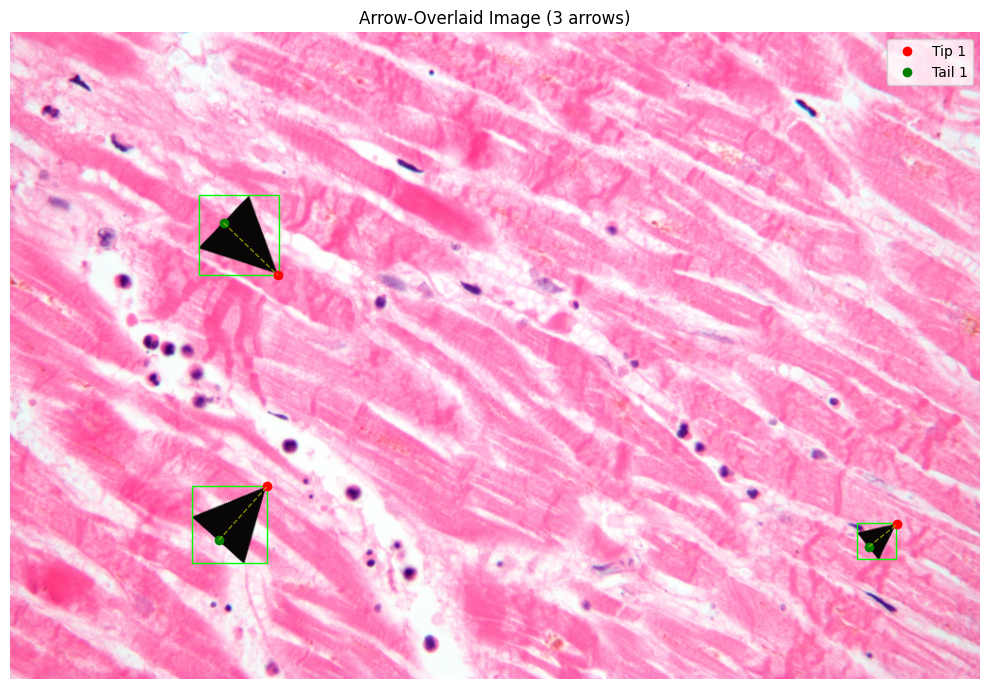

In [286]:
# Load base medical image and generate arrow-overlaid image using new function
base_image_path = "medical-images-example/image1.jpg"
arrow_dir = "arrow-pngs"

# Use the main wrapper function
output_rgb, tips, tails, bboxes = generate_arrow_overlaid_image(
    base_image_path, arrow_dir, target_width=1024, num_arrows=3
)

# Display result
plt.figure(figsize=(10, 8))
plt.imshow(output_rgb)
# Mark each tip and tail location
for i, (tip, tail) in enumerate(zip(tips, tails), start=1):
    plt.plot(tip[0], tip[1], 'ro', markersize=6, markeredgewidth=1, label=f'Tip {i}' if i == 1 else '')
    plt.plot(tail[0], tail[1], 'go', markersize=6, markeredgewidth=1, label=f'Tail {i}' if i == 1 else '')
    # Draw line from tail to tip
    plt.plot([tail[0], tip[0]], [tail[1], tip[1]], 'y--', linewidth=1, alpha=0.7)

# Draw bounding boxes
for i, bbox in enumerate(bboxes, start=1):
    bx0, by0, bx1, by1 = bbox
    width = bx1 - bx0
    height = by1 - by0
    rect = patches.Rectangle((bx0, by0), width, height, linewidth=1, edgecolor='lime', facecolor='none')
    plt.gca().add_patch(rect)

plt.title(f"Arrow-Overlaid Image ({len(bboxes)} arrows)")
plt.legend(loc='upper right')
plt.axis('off')
plt.tight_layout()
plt.show()

## Dataset Generation

In [288]:
# Batch-generate overlaid arrow images for the dataset with train/valid/test splits

medical_dir = "medical-images-example"
arrow_dir = "arrow-pngs"
output_base_dir = "dataset-example"

# Create YOLO-style folder structure
train_img_dir = os.path.join(output_base_dir, "train", "images")
train_label_dir = os.path.join(output_base_dir, "train", "labels")
valid_img_dir = os.path.join(output_base_dir, "valid", "images")
valid_label_dir = os.path.join(output_base_dir, "valid", "labels")
test_img_dir = os.path.join(output_base_dir, "test", "images")
test_label_dir = os.path.join(output_base_dir, "test", "labels")

for dir_path in [train_img_dir, train_label_dir, valid_img_dir, valid_label_dir, test_img_dir, test_label_dir]:
    os.makedirs(dir_path, exist_ok=True)

# Collect medical images (common extensions)
valid_exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}
medical_files = [f for f in os.listdir(medical_dir) if os.path.splitext(f)[1].lower() in valid_exts]
if not medical_files:
    raise ValueError(f"No images found in {medical_dir} with extensions {sorted(valid_exts)}")

# Double the list for data augmentation (each image will be used twice with different random arrows)
medical_files = medical_files * 2

# Randomize the order of files
random.shuffle(medical_files)

# Calculate split indices (80/10/10)
total_files = len(medical_files)
train_end = int(0.8 * total_files)
valid_end = int(0.9 * total_files)

train_files = medical_files[:train_end]
valid_files = medical_files[train_end:valid_end]
test_files = medical_files[valid_end:]

print(f"Found {len(set(medical_files))} unique medical images.")
print(f"Doubled to {len(medical_files)} total for 2x augmentation.")
print(f"Split: Train={len(train_files)}, Valid={len(valid_files)}, Test={len(test_files)}")
print(f"Writing to '{output_base_dir}' with YOLO folder structure.")

# Process each split
for split_name, split_files, img_dir, label_dir in [
    ("train", train_files, train_img_dir, train_label_dir),
    ("valid", valid_files, valid_img_dir, valid_label_dir),
    ("test", test_files, test_img_dir, test_label_dir)
]:
    print(f"\nProcessing {split_name} split ({len(split_files)} images)...")
    
    for idx, img_name in enumerate(split_files, start=1):
        try:
            base_image_path = os.path.join(medical_dir, img_name)
            
            # Use the new wrapper function
            output_rgb, tips, tails, bboxes = generate_arrow_overlaid_image(
                base_image_path, arrow_dir, target_width=1024, num_arrows=None
            )
            
            base_h, base_w = output_rgb.shape[:2]

            # Save output image with numeric index
            img_ext = os.path.splitext(img_name)[1]
            out_path = os.path.join(img_dir, f"{idx}{img_ext}")
            output_bgr = cv2.cvtColor(output_rgb, cv2.COLOR_RGB2BGR)
            ok = cv2.imwrite(out_path, output_bgr)
            if not ok:
                print(f"[Warn] Failed to write: {out_path}")
                continue

            # Write YOLO pose-format labels (one line per arrow: class 0, bbox + tip/tail keypoints)
            label_path = os.path.join(label_dir, f"{idx}.txt")
            with open(label_path, "w", encoding="utf-8") as f:
                for tip, tail, bbox in zip(tips, tails, bboxes):
                    bx0, by0, bx1, by1 = bbox
                    cx = (bx0 + bx1) / 2.0 / base_w
                    cy = (by0 + by1) / 2.0 / base_h
                    bw = (bx1 - bx0) / base_w
                    bh = (by1 - by0) / base_h
                    tip_xn, tip_yn = tip[0] / base_w, tip[1] / base_h
                    tail_xn, tail_yn = tail[0] / base_w, tail[1] / base_h
                    label_line = f"0 {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f} {tip_xn:.6f} {tip_yn:.6f} 2 {tail_xn:.6f} {tail_yn:.6f} 2"
                    f.write(label_line + "\n")

            if idx % 10 == 0 or idx == len(split_files):
                print(f"  {split_name}: {idx}/{len(split_files)} | arrows={len(bboxes)}")

        except Exception as e:
            print(f"[Error] Skipping {img_name} due to error: {e}")
            continue

print(f"\n{'='*60}")
print(f"Dataset generation complete!")
print(f"Structure:")
print(f"  {output_base_dir}/train/images & labels ({len(train_files)} images)")
print(f"  {output_base_dir}/valid/images & labels ({len(valid_files)} images)")
print(f"  {output_base_dir}/test/images & labels ({len(test_files)} images)")
print(f"{'='*60}")

Found 10 unique medical images.
Doubled to 20 total for 2x augmentation.
Split: Train=16, Valid=2, Test=2
Writing to 'dataset-example' with YOLO folder structure.

Processing train split (16 images)...
  train: 10/16 | arrows=4
  train: 16/16 | arrows=5

Processing valid split (2 images)...
  valid: 2/2 | arrows=0

Processing test split (2 images)...
  test: 2/2 | arrows=3

Dataset generation complete!
Structure:
  dataset-example/train/images & labels (16 images)
  dataset-example/valid/images & labels (2 images)
  dataset-example/test/images & labels (2 images)


### Visualize Generated Labels

Verify that the YOLO pose format annotations are correct by visualizing the first generated image with its labels.

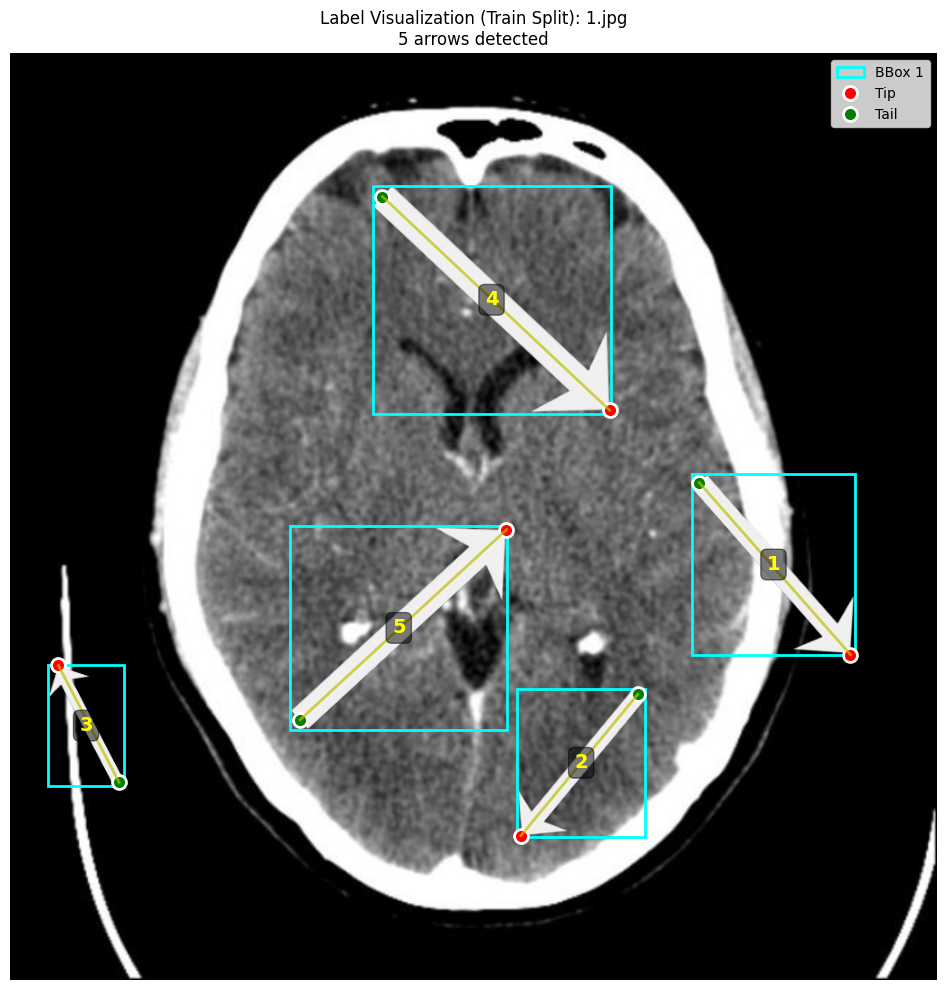


Image: train/images/1.jpg (1024x1024)
Label file: train/labels/1.txt

Arrow 1:
  Class: 0
  BBox (normalized): cx=0.8232, cy=0.5513, w=0.1758, h=0.1943
  Tip (normalized): x=0.9062, y=0.6484 | visibility: 2
  Tail (normalized): x=0.7432, y=0.4629 | visibility: 2

Arrow 2:
  Class: 0
  BBox (normalized): cx=0.6157, cy=0.7651, w=0.1377, h=0.1592
  Tip (normalized): x=0.5508, y=0.8438 | visibility: 2
  Tail (normalized): x=0.6768, y=0.6914 | visibility: 2

Arrow 3:
  Class: 0
  BBox (normalized): cx=0.0815, cy=0.7251, w=0.0811, h=0.1299
  Tip (normalized): x=0.0518, y=0.6602 | visibility: 2
  Tail (normalized): x=0.1172, y=0.7861 | visibility: 2

Arrow 4:
  Class: 0
  BBox (normalized): cx=0.5190, cy=0.2656, w=0.2568, h=0.2461
  Tip (normalized): x=0.6465, y=0.3848 | visibility: 2
  Tail (normalized): x=0.4014, y=0.1543 | visibility: 2

Arrow 5:
  Class: 0
  BBox (normalized): cx=0.4189, cy=0.6196, w=0.2344, h=0.2197
  Tip (normalized): x=0.5352, y=0.5137 | visibility: 2
  Tail (normaliz

In [485]:
# Load the first generated image and its label from the train split
dataset_base_dir = "dataset-example"
train_img_dir = os.path.join(dataset_base_dir, "train", "images")
train_label_dir = os.path.join(dataset_base_dir, "train", "labels")

# Find first image (could be any extension)
valid_exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}
img_files = sorted([f for f in os.listdir(train_img_dir) if os.path.splitext(f)[1].lower() in valid_exts])
if not img_files:
    print("No generated images found! Run the dataset generation cell first.")
else:
    first_img = img_files[0]
    img_path = os.path.join(train_img_dir, first_img)
    
    # Get corresponding label file (same name but .txt extension)
    img_basename = os.path.splitext(first_img)[0]
    label_path = os.path.join(train_label_dir, f"{img_basename}.txt")
    
    # Load image
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img_rgb.shape[:2]
    
    # Parse label file
    arrows = []
    with open(label_path, "r") as f:
        for line in f:
            parts = list(map(float, line.strip().split()))
            if len(parts) == 11:  # class, cx, cy, w, h, tip_x, tip_y, tip_vis, tail_x, tail_y, tail_vis
                class_id, cx, cy, bw, bh, tip_x, tip_y, tip_vis, tail_x, tail_y, tail_vis = parts
                arrows.append({
                    'class': int(class_id),
                    'bbox': (cx, cy, bw, bh),
                    'tip': (tip_x, tip_y),
                    'tip_visibility': int(tip_vis),
                    'tail': (tail_x, tail_y),
                    'tail_visibility': int(tail_vis)
                })
            elif len(parts) == 9:  # Legacy format without visibility (backward compatibility)
                class_id, cx, cy, bw, bh, tip_x, tip_y, tail_x, tail_y = parts
                arrows.append({
                    'class': int(class_id),
                    'bbox': (cx, cy, bw, bh),
                    'tip': (tip_x, tip_y),
                    'tip_visibility': 2,
                    'tail': (tail_x, tail_y),
                    'tail_visibility': 2
                })
    
    # Visualize
    plt.figure(figsize=(12, 10))
    plt.imshow(img_rgb)
    
    for i, arrow in enumerate(arrows, start=1):
        # Convert normalized coords back to pixel coords
        cx_norm, cy_norm, bw_norm, bh_norm = arrow['bbox']
        cx_px = cx_norm * w
        cy_px = cy_norm * h
        bw_px = bw_norm * w
        bh_px = bh_norm * h
        
        # Bbox corners
        x1 = cx_px - bw_px / 2
        y1 = cy_px - bh_px / 2
        
        # Draw bbox
        rect = patches.Rectangle((x1, y1), bw_px, bh_px, 
                                linewidth=2, edgecolor='cyan', facecolor='none',
                                label=f'BBox {i}' if i == 1 else '')
        plt.gca().add_patch(rect)
        
        # Draw keypoints
        tip_x_px = arrow['tip'][0] * w
        tip_y_px = arrow['tip'][1] * h
        tail_x_px = arrow['tail'][0] * w
        tail_y_px = arrow['tail'][1] * h
        
        plt.plot(tip_x_px, tip_y_px, 'ro', markersize=10, markeredgewidth=2, 
                markeredgecolor='white', label=f'Tip' if i == 1 else '')
        plt.plot(tail_x_px, tail_y_px, 'go', markersize=10, markeredgewidth=2,
                markeredgecolor='white', label=f'Tail' if i == 1 else '')
        
        # Draw arrow line
        plt.plot([tail_x_px, tip_x_px], [tail_y_px, tip_y_px], 
                'y-', linewidth=2, alpha=0.7)
        
        # Add text annotation
        plt.text(cx_px, cy_px, f'{i}', color='yellow', fontsize=14, 
                fontweight='bold', ha='center', va='center',
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.5))
    
    plt.title(f"Label Visualization (Train Split): {first_img}\n{len(arrows)} arrows detected")
    plt.legend(loc='upper right')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Print label details for verification
    print(f"\n{'='*60}")
    print(f"Image: train/images/{first_img} ({w}x{h})")
    print(f"Label file: train/labels/{img_basename}.txt")
    print(f"{'='*60}")
    for i, arrow in enumerate(arrows, start=1):
        print(f"\nArrow {i}:")
        print(f"  Class: {arrow['class']}")
        print(f"  BBox (normalized): cx={arrow['bbox'][0]:.4f}, cy={arrow['bbox'][1]:.4f}, w={arrow['bbox'][2]:.4f}, h={arrow['bbox'][3]:.4f}")
        print(f"  Tip (normalized): x={arrow['tip'][0]:.4f}, y={arrow['tip'][1]:.4f} | visibility: {arrow['tip_visibility']}")
        print(f"  Tail (normalized): x={arrow['tail'][0]:.4f}, y={arrow['tail'][1]:.4f} | visibility: {arrow['tail_visibility']}")